In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
#library(themis)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
#reading in the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "HTRU2.zip") 
unzip("HTRU2.zip")
col_names <- c('Mean_IP', 'Stdev_IP', 'Kurtosis_IP', 'Skewness_IP', 
               'Mean_DM', "Stdev_DM", 'Kurtosis_DM', "Skewness_DM", "Class")
pulsar_data <- read_csv('HTRU_2.csv', col_names)



Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kur...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Summary stats for each method
pulsar_data_summary <- group_by(pulsar_data, Class) |>
    summarize(avg_mean_ip = mean(Mean_IP), mean_stdev_ip = mean(Stdev_IP), 
              avg_mean_dm = mean(Mean_DM), mean_stdev_dm = mean(Stdev_DM), 
              count = n(),
             max_ip = max(Mean_IP), min_ip = min(Mean_IP)) |>
    mutate (as.factor(Class)) 

pulsar_data_IP_summary <- select(pulsar_data_summary, Class, avg_mean_ip, mean_stdev_ip, count)
pulsar_data_IP_summary

pulsar_data_DM_summary <- select(pulsar_data_summary, Class, avg_mean_dm, mean_stdev_dm, count)
pulsar_data_DM_summary


Class,avg_mean_ip,mean_stdev_ip,count
<dbl>,<dbl>,<dbl>,<int>
0,116.56273,47.33974,16259
1,56.69061,38.71060,1639


Class,avg_mean_dm,mean_stdev_dm,count
<dbl>,<dbl>,<dbl>,<int>
0,8.863258,23.28798,16259
1,49.825995,56.46896,1639


In [6]:
#Wrangling the data a bit
options(repr.matrix.max.rows = 6)

pulsar_data_wrangled <- mutate(pulsar_data, Class = as.factor(Class))

pulsar_data_IP <- select(pulsar_data_wrangled, Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Class)
pulsar_data_IP

pulsar_data_DM <- select(pulsar_data_wrangled, Mean_DM, Stdev_DM, Kurtosis_DM, Skewness_DM, Class)
pulsar_data_DM


Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,0
102.5078,58.88243,0.4653182,-0.5150879,0
103.0156,39.34165,0.3233284,1.0511644,0
⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,0
114.5078,53.90240,0.2011614,-0.02478884,0
57.0625,85.79734,1.4063910,0.08951971,0


Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.199833,19.11043,7.975532,74.24222,0
1.677258,14.86015,10.576487,127.39358,0
3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮
21.430602,58.87200,2.499517,4.595173,0
1.946488,13.38173,10.007967,134.238910,0
188.306020,64.71256,-1.597527,1.429475,0


In [7]:
#Number of each variable
IP_num_obs <- nrow(pulsar_data_IP)
pulsar_data_IP |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / IP_num_obs * 100)
IP_num_obs


DM_num_obs <- nrow(pulsar_data_DM)
pulsar_data_DM |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / DM_num_obs * 100)
DM_num_obs

Class,count,percentage
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


[1] 17898

Class,count,percentage
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


[1] 17898

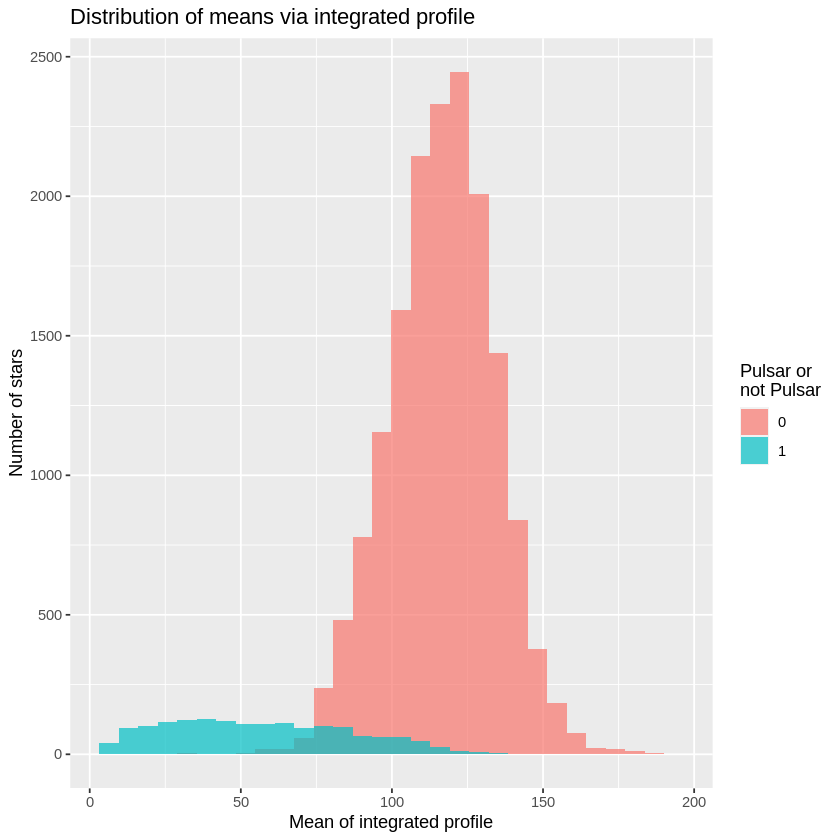

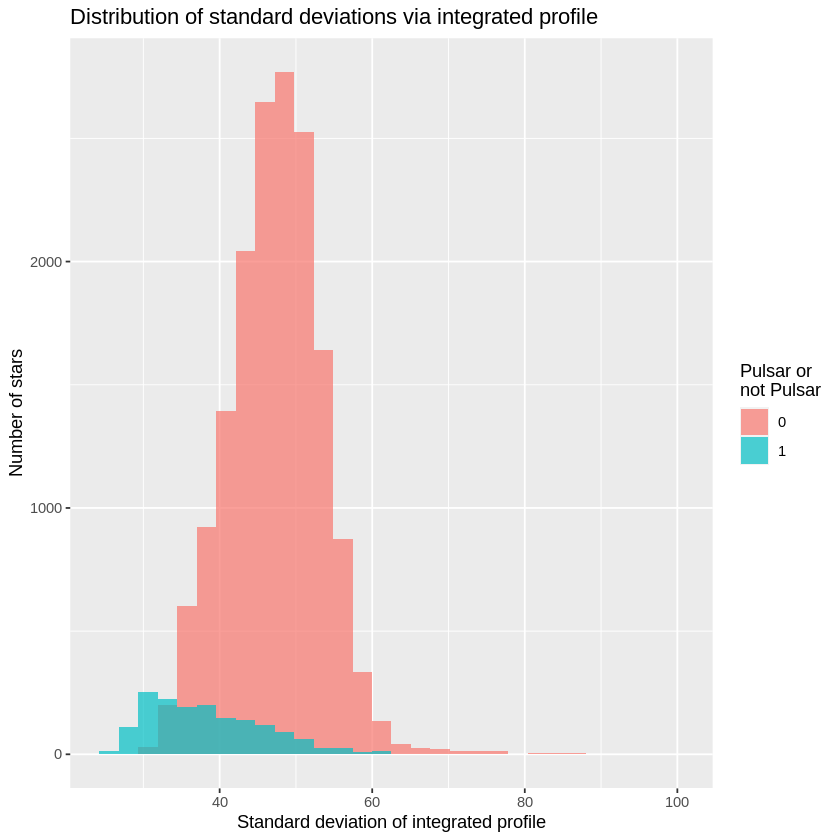

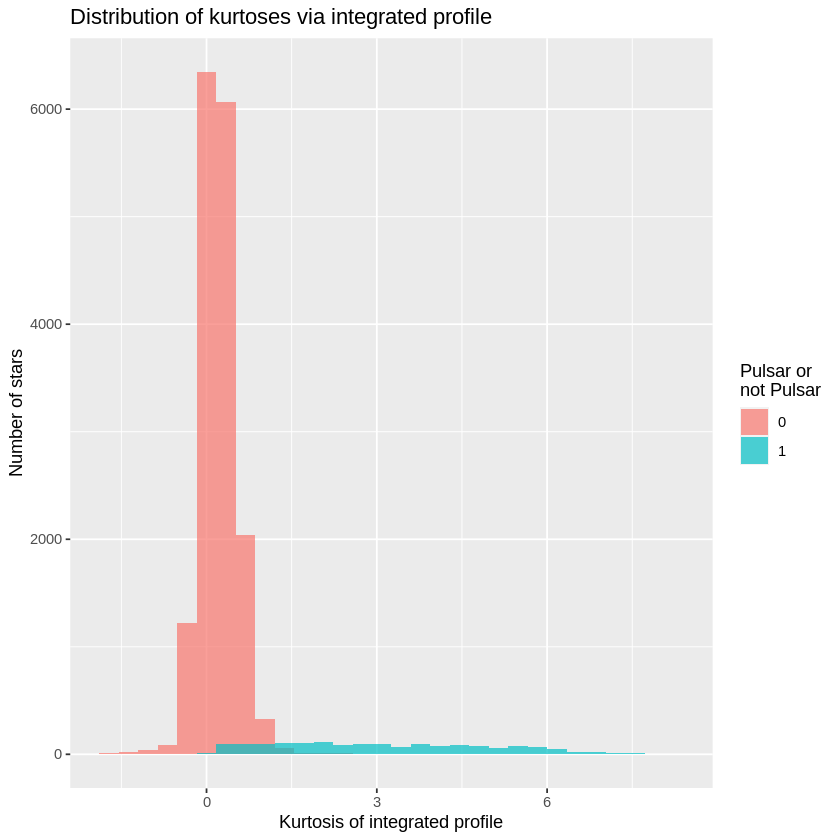

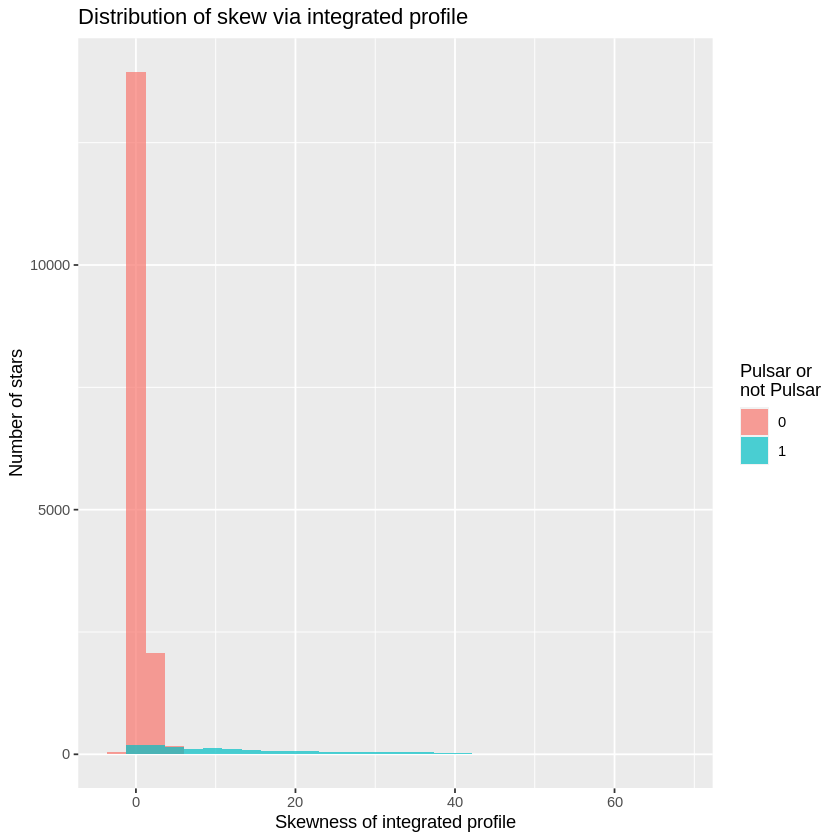

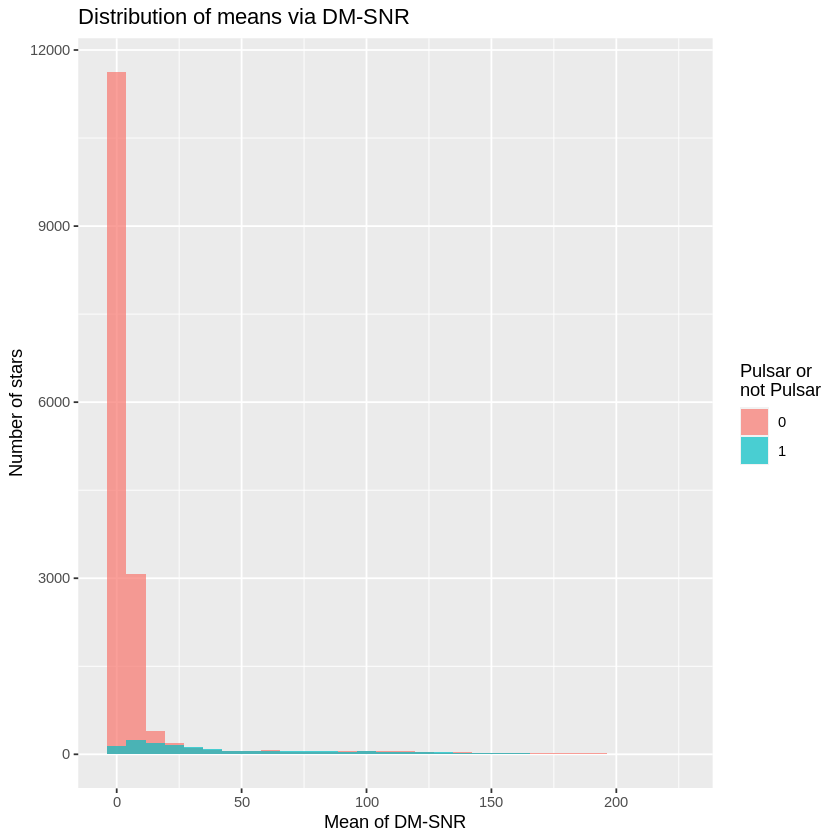

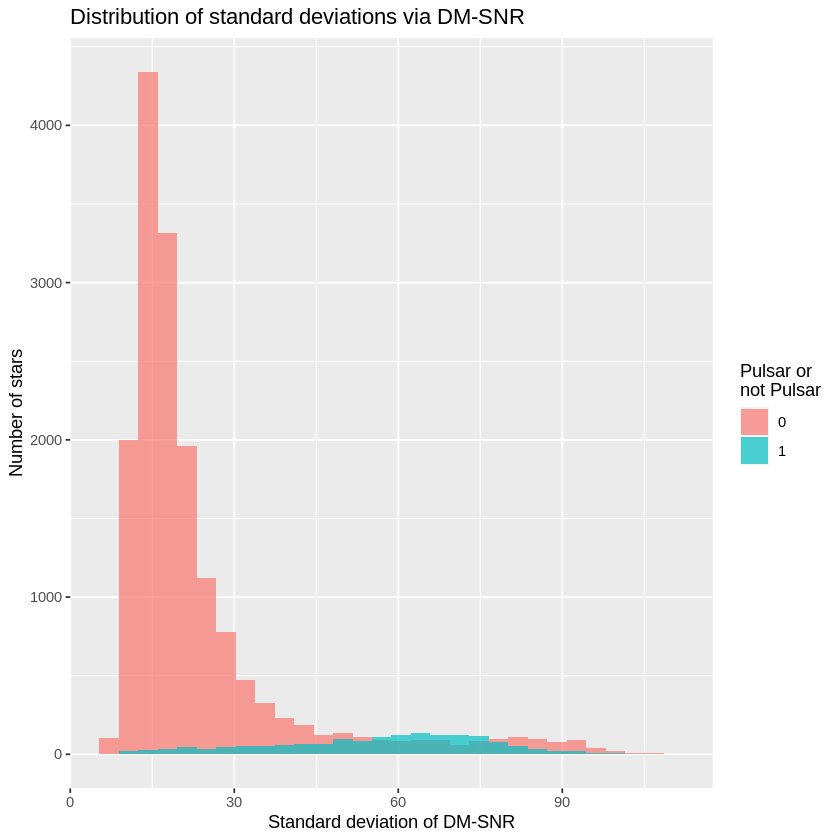

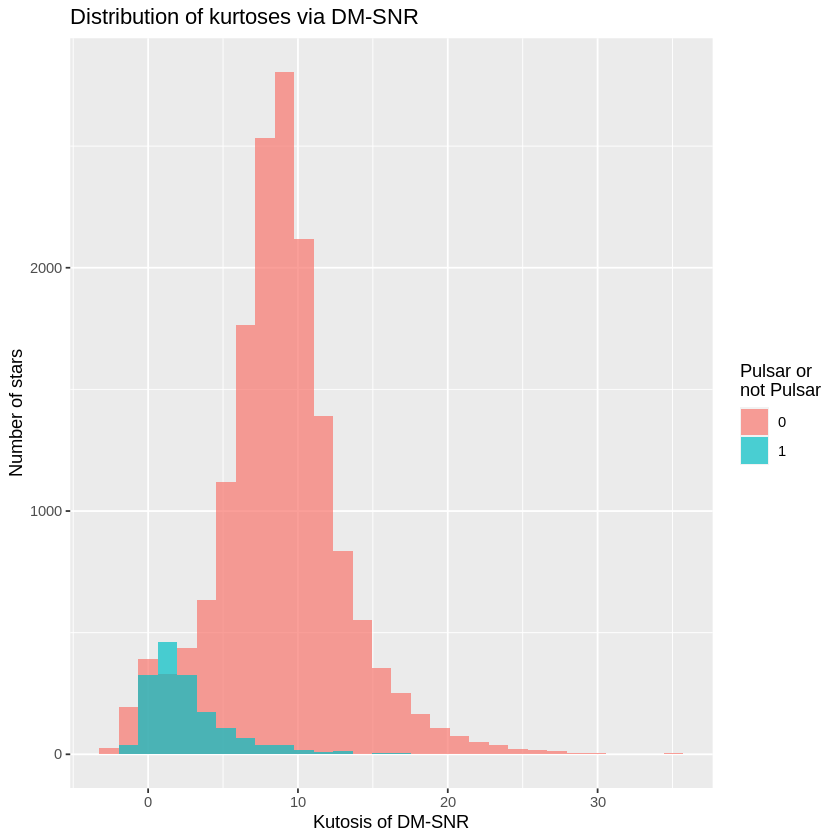

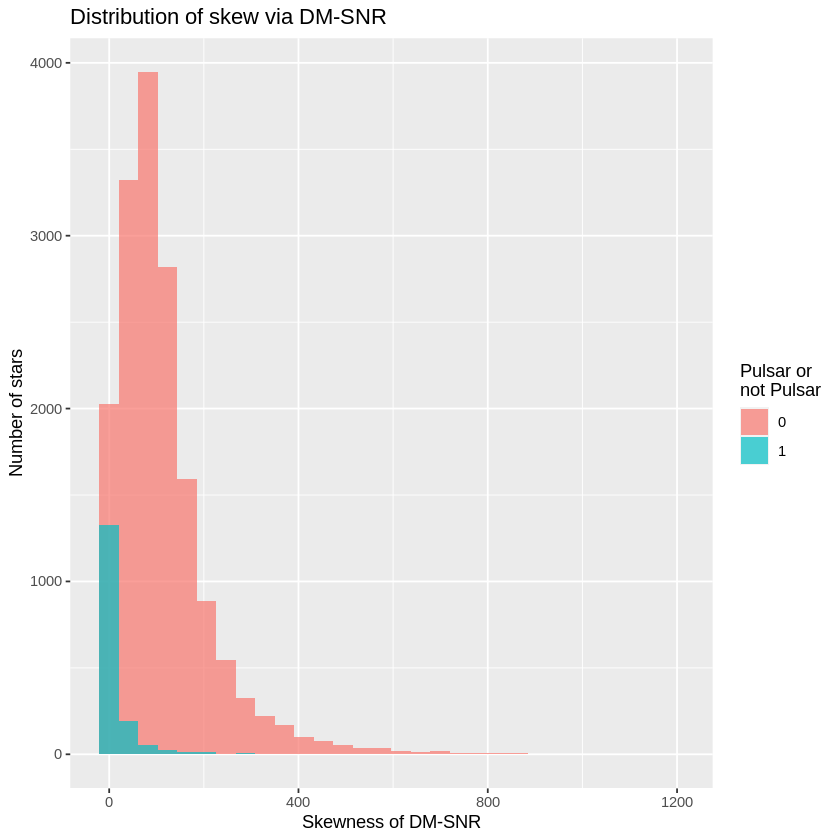

In [8]:
#Basic histograms of means
pulsar_hist_mean_IP <- ggplot(pulsar_data_IP, aes(x = Mean_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Mean of integrated profile", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of means via integrated profile')
pulsar_hist_mean_IP

pulsar_hist_SD_IP <- ggplot(pulsar_data_IP, aes(x = Stdev_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Standard deviation of integrated profile", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of standard deviations via integrated profile')
pulsar_hist_SD_IP

pulsar_hist_Kurtosis_IP <- ggplot(pulsar_data_IP, aes(x = Kurtosis_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Kurtosis of integrated profile", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of kurtoses via integrated profile')
pulsar_hist_Kurtosis_IP

pulsar_hist_Skew_IP <- ggplot(pulsar_data_IP, aes(x = Skewness_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Skewness of integrated profile", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of skew via integrated profile')
pulsar_hist_Skew_IP


pulsar_hist_mean_DM <- ggplot(pulsar_data_DM, aes(x = Mean_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Mean of DM-SNR", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of means via DM-SNR')
pulsar_hist_mean_DM

pulsar_hist_SD_DM <- ggplot(pulsar_data_DM, aes(x = Stdev_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Standard deviation of DM-SNR", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of standard deviations via DM-SNR')
pulsar_hist_SD_DM

pulsar_hist_Kurtosis_DM <- ggplot(pulsar_data_DM, aes(x = Kurtosis_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Kutosis of DM-SNR", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of kurtoses via DM-SNR')
pulsar_hist_Kurtosis_DM

pulsar_hist_Skew_DM <- ggplot(pulsar_data_DM, aes(x = Skewness_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    labs(x="Skewness of DM-SNR", 
         y= "Number of stars", 
         fill = "Pulsar or \nnot Pulsar", 
         title = 'Distribution of skew via DM-SNR')
pulsar_hist_Skew_DM

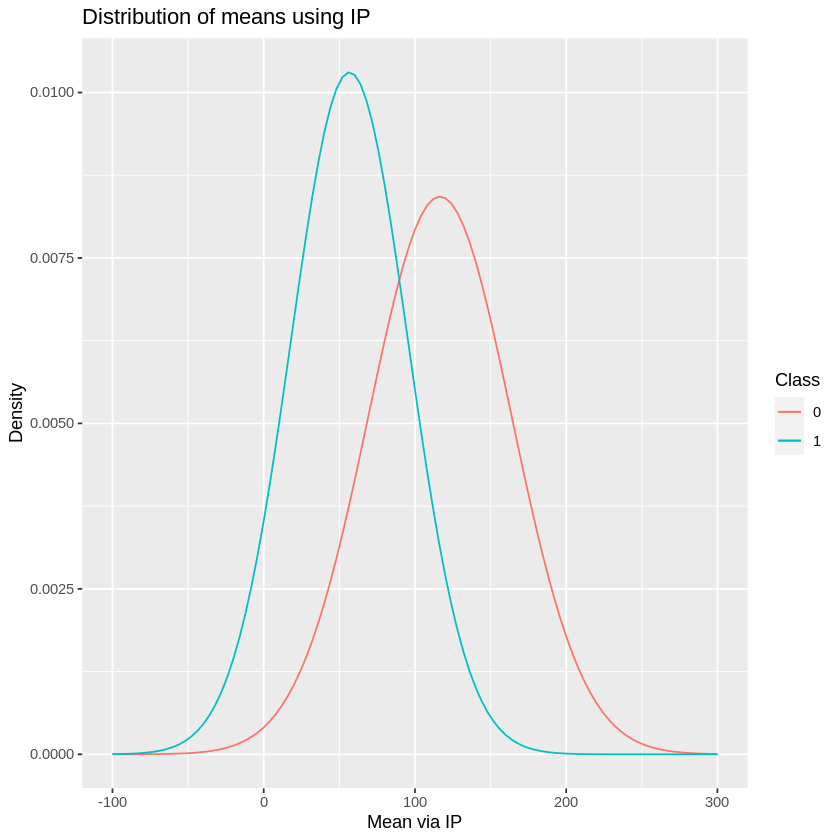

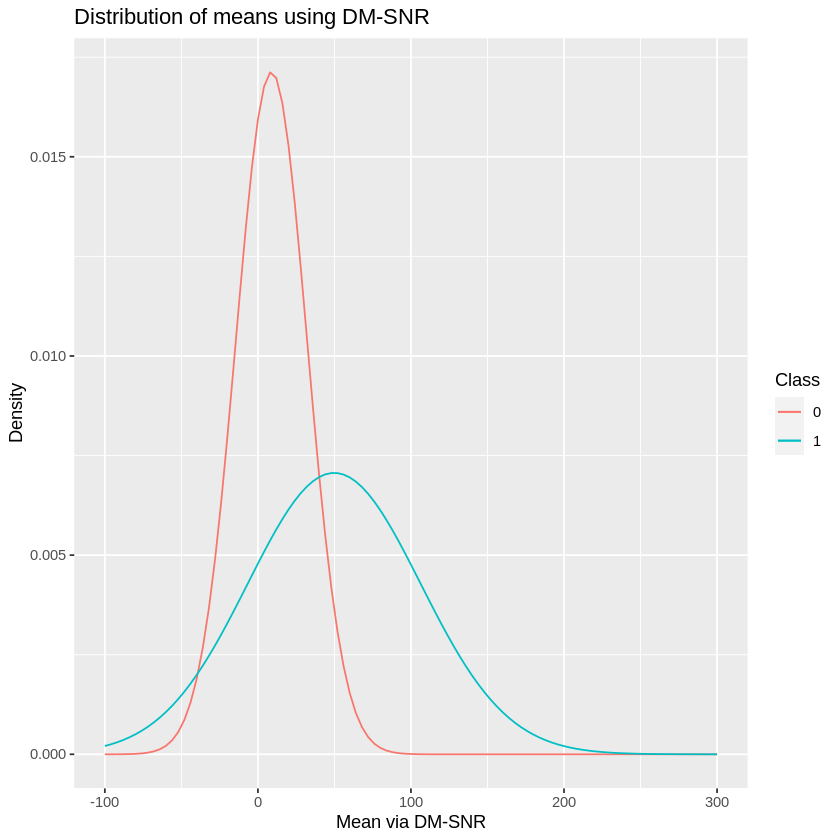

In [7]:
#Normal distribution of avg means of each type
IP_distribution <- ggplot() + 
  lapply(split(pulsar_data_IP_summary, seq_len(nrow(pulsar_data_IP_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_ip, sd = x$mean_stdev_ip), 
                            aes(color = factor(x$Class)))) +
  xlim(-100,300)+
    labs(x = 'Mean via IP', y = 'Density', color = 'Class', 
         title = 'Distribution of means using IP')
IP_distribution

DM_distribution <- ggplot() + 
  lapply(split(pulsar_data_DM_summary, seq_len(nrow(pulsar_data_DM_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_dm, sd = x$mean_stdev_dm), 
                            aes(color = factor(x$Class)))) +
  xlim(-100,300)+
    labs(x = 'Mean via DM-SNR', y = 'Density', color = 'Class', 
         title = 'Distribution of means using DM-SNR')
DM_distribution

# t-test

Next, we compute if the difference in means between pulsar stars and non-pulsar stars is significant for the integrated and DM-SNR profiles. We are doing this because we want to forumlate a hypothesis on which profile will be better to predict if a star is a pulsar or not. Although both the integrated and DM-SNR profiles are effective at telling a pulsar and non-pusar star apart, our results show that the integrated profile seems to have a larger difference between the mean value of a pulsar star and non pulsar star. 

**Thus, we hypothesize that if we use the integrated profile to predict pulsar star class, we will get more accurate results than if we use the DM-SNR profile to make those same predictions.**

In [9]:
set.seed(0)

integrated_pulsar <- rnorm(1639, mean = 56.69061, sd = 38.71060)
integrated_non_pulsar <- rnorm(16259, mean= 116.56273, sd = 47.33974)

integrated_profile_t_test_result <- t.test(integrated_non_pulsar, integrated_pulsar, alternative = "two.sided", var.equal = TRUE)
integrated_profile_t_test_result

DM_pulsar <- rnorm(1639, mean = 8.863258, sd = 23.28798)
DM_non_pulsar <- rnorm(16259, mean= 49.825995, sd = 56.46896)

DM_profile_t_test_result <- t.test(DM_non_pulsar, DM_pulsar, alternative = "two.sided", var.equal = TRUE)
DM_profile_t_test_result


	Two Sample t-test

data:  integrated_non_pulsar and integrated_pulsar
t = 50.911, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 59.02770 63.75493
sample estimates:
mean of x mean of y 
117.04144  55.65013 



	Two Sample t-test

data:  DM_non_pulsar and DM_pulsar
t = 29.638, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 39.29613 44.86195
sample estimates:
mean of x mean of y 
50.180184  8.101145 


# knn classification

In [ ]:
set.seed(17)

IP_split <- initial_split(pulsar_data_IP, prop = 0.75, strata = Class)
IP_train <- training(IP_split)
IP_test <- testing(IP_split) 

IP_proportions <- IP_train |>
                      group_by(Class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(IP_train))

IP_proportions

IP_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(IP_recipe) |>
  add_model(knn_spec) |>
  fit(data = IP_train)

IP_predictions <- predict(knn_fit, IP_test) |>
  bind_cols(IP_test) |>
  conf_mat(truth = Class, estimate = .pred_class)
IP_predictions



Class,n,percent
<fct>,<int>,<dbl>
0,12201,90.896223
1,1222,9.103777


Warning message:
“tune samples were requested but there were 13423 rows in the data. 13418 will be used.”


In [30]:
#knn with cross-validation to pick K
IP_split <- initial_split(pulsar_data_IP, prop = 0.75, strata = Class)
IP_train <- training(IP_split)
IP_test <- testing(IP_split) 

IP_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

IP_vfold <- vfold_cv(IP_train, v = 5, strata = Class)

IP_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(IP_recipe) |>
  add_model(IP_spec) |>
  fit_resamples(resamples = IP_vfold) |>
  collect_metrics()

validation_predicted <- predict(knn_fit, cancer_validation) |>
  bind_cols(cancer_validation)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

IP_results <- workflow() |>
  add_recipe(IP_recipe) |>
  add_model(IP_spec) |>
  tune_grid(resamples = IP_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- IP_results |>
  filter(.metric == "accuracy")
accuracies

ERROR: [1m[33mError[39m:[22m
[33m![39m 1 argument has been tagged for tuning in this component: model_spec. 
Please use one of the tuning functions (e.g. `tune_grid()`) to optimize them.
